<a href="https://colab.research.google.com/github/gabriel-barata/Analise-de-Satisfacao-de-Clientes-para-o-iFood/blob/main/SENTIMENT_ANALYSIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INTRODUÇÃO

Nesta aba daremos continuidade ao projeto, fazendo limpeza dos dados, analise exploratória e modelagem dos dados que serão classificados em 'bons', 'ruins' e 'neutros.

O Objetivo principal deste kernel é tomar conhecimento das principais reclamações a respeito da marca *iFood* durante a semana através da analise de suas citações no *Twitter*, e propor contramedidas.

sobre os dados :
+ foram obtidos através de requisição na API do *Twitter*, portanto estão sujeitos a algumas limitações como data dos dados, os tweets datam de no máximo 7 dias atrás.

# PREPARAÇÃO DO AMBIENTE

Nesta aba importamos bibliotecas, setamos parametros e definimos alguma variáveis globais que serão usadas ao longo do notebook.

## Imports

Aba de importação de bibliotecas.

In [125]:
import pandas as pd
import numpy as np
import datetime
import sys

from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns

from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
import spacy
import re

from google.colab import drive
import warnings

## Parametros Globais

Estabelecendo alguns parametros e variaveis que serão usados em todo o notebook.

In [104]:
# Para evitar o retorno de avisos
warnings.filterwarnings('ignore')

# Montando o drive que contém os dados
drive.mount('/content/drive/')

# Alocando os dados em tabelas
tweets_data_raw = pd.read_csv('/content/drive/MyDrive/BASES DE DADOS/TWITTER DATA/iFood/tweets.csv')
users_data_raw = pd.read_csv('/content/drive/MyDrive/BASES DE DADOS/TWITTER DATA/iFood/users_data.csv')

# Parametros de vizualização
pd.set_option("display.max_colwidth", -1)
matplotlib.rcParams['axes.facecolor'] = '#E5E5E5'
BLUE, RED = '#0864D2', '#FF0000'

# Clonando repositório do github que será usada no trabalho
!git clone https://github.com/rafjaa/LeIA.git &> /dev/null
sys.path.append('/content/')

!python -m spacy download pt_core_news_sm &> /dev/null
nlp = spacy.load('pt_core_news_sm', disable = ['tagger', 'parser', 'attribute_ruler', 'ner', 'tok2vec', 'lemmatizer'])

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# ANALISE DE SENTIMENTO

Nesta etapa trataremos os dados para modelagem, a modelagem consiste na obtenção do sentimento principal atrelado ao tweet através da presença de determinadas palavras.

## Limpeza

Antes da modelagem de fato faremos limpeza nos dados. Essa limpeza consiste inicialmente em tratar algumas deformidas causadas pelo metodo de obtenção. Reunimos todos os tweets e então agregamos suas métricas publicas e seus autores originais, ao fim desse processo obtemos 10686 dados para trabalharmos(antes eram 19 mil), perdemos em numeros mas melhoramos consideravelmente a qualidade dos dados.

Após isso a limpeza segue e faremos:
+ redução de todos os caracteres de todas as palavras a minusculos.
+ remoção de links, pontuações e menções que não agregam em valor semantico, apenas nos trariam mais complexidade computacional.

O Algoritmo que será usado remove automáticamente pontuações e faz correção ortográfica por isso não será necessário fazer.

In [3]:
# Removendo colunas, fazendo conversão de tipos de variáveis e removendo tags de retweet
tweets_data_raw.drop('Unnamed: 0', axis = 1, inplace = True)
tweets_data_raw['user_id'] = tweets_data_raw['user_id'].astype(str)
tweets_data_raw['tweet'] = tweets_data_raw['tweet'].apply(lambda x: x.replace('RT ', ''))

# Separando os dados em partes para facilitar a limpeza e então reagrengando em uma unica base de dados
tweets_and_users = tweets_data_raw.groupby('tweet').agg({'user_id' : ','.join}).reset_index()
tweets_and_users['user_id'] = tweets_and_users['user_id'].apply(lambda x: x.split(',')[0])
dates = tweets_data_raw.groupby('tweet').agg({'twt_date' : ','.join}).reset_index()
dates['twt_date'] = dates['twt_date'].apply(lambda x: x.split(',')[0])
temp = pd.merge(tweets_and_users, dates, on = 'tweet')
metrics = tweets_data_raw.groupby('tweet')['retweet_count', 'like_count'].sum().reset_index()
tweets_data = pd.merge(temp, metrics, on = 'tweet')

# Convertendo os valores temporais a objetos .datetime
tweets_data['twt_date'] = tweets_data['twt_date'].apply(lambda x: x.replace('T', ' '))
tweets_data['twt_date'] = tweets_data['twt_date'].apply(lambda x: x.split('.')[0])
tweets_data['twt_date'] = tweets_data['twt_date'].apply(lambda x: datetime.datetime.strptime(x , '%Y-%m-%d %H:%M:%S'))
tweets_data.sort_values('twt_date', ascending = True, inplace = True)

# Organizando os dados por data de publicação
tweets_data = tweets_data.sort_values('twt_date', ascending = True).reset_index(drop = True)

# Removendo links, menções e pontuações
temp = [re.sub(r'http\S+', '', tweet) for tweet in list(tweets_data['tweet'].apply(lambda x: x.lower()))]
temp = [re.sub(r'@[A-Za-z0-9]+', '',tweet) for tweet in temp]
cleaned_tweets = [re.sub(r'[^\w\s]', '', tweet) for tweet in temp]

## Polarização

Para fazer a polarização utilizaremos o LeIA que é o Léxico para Inferência Adaptada, um fork do léxico e ferramenta para análise de sentimentos VADER (Valence Aware Dictionary and sEntiment Reasoner) adaptado para textos em português, com suporte para emojis e foco na análise de sentimentos de textos expressos em mídias sociais. O fork é de autoria de Rafel Almeida e está disponivel para consulta em https://github.com/rafjaa/LeIA.

O modelo possui uma pontuação atribuida a cada palavra dependendo do sentimento que carrega e da intensidade desse sentimento, variando esta pontuação entre -1 (sentimento negativo) até +1 (sentimento positivo) e passando pelo 0 que indicaria neutralidade.
O modelo é sensitivo a intensidade da emoção, que é dada pela soma das intensidades das palavras presentes no texto.

A partir da pontuação dada pela polarização atribuiremos tendencias a cada *tweet*.

In [4]:
from LeIA.leia import SentimentIntensityAnalyzer

s = SentimentIntensityAnalyzer()

polaridades = []

for sentence in cleaned_tweets:
  polaridade = s.polarity_scores(sentence)['compound']
  polaridades.append(polaridade)

tweets_data['polaridade'] = polaridades

def get_trend(compound):

  '''Função usada para extrair as tendencia de cada tweet baseado na sua polaridade atribuida pelo LeIA
  '''
  if compound > 0.25:
    return 'positivo'
  elif compound < -0.25:
    return 'negativo'
  else:
    return 'neutro'

tweets_data['sentimento'] = tweets_data['polaridade'].map(get_trend)

print('Os 3 tweets classificados como mais positivos desta semana')
display(tweets_data.nlargest(3, 'polaridade'))
print('\n')
print('Os 3 tweets classificados como mais negativos desta semana')
display(tweets_data.nsmallest(3, 'polaridade'))

Os 3 tweets classificados como mais positivos desta semana


,tweet,user_id,twt_date,retweet_count,like_count,polaridade,sentimento
2516,"08:28 e eu editando caldinhos no ifood ☺️🙌🏼 Deus obrigado por trabalhar alimentando e dando sabor e um pouco de prazer e saude no dia a dia das pessoas, sou grata por isso! Na verdade eu sou muito feliz cozinhando, faço isso com tanto carinho que nem sei medir…",997223912860774402,2022-06-22 11:28:21,0,3,0.9585,positivo
8677,@BastidoresFla O maior entregador @iFood do @Flamengo da história sairá em grande estilo? 😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂😂O senso de humor de parte de nossa torcida é invejável superando grandes talentos do @ComedyCentralBR,910497909967343616,2022-06-26 01:36:10,0,1,0.9584,positivo
1639,minha amiga fez aniversário e mandei ifood de presente ela ficou super feliz e agora tô feliz tbm ❤️❤️❤️ ela é meu presentinho q o cp me deu,935126257104314368,2022-06-21 19:31:49,0,0,0.9432,positivo




Os 3 tweets classificados como mais negativos desta semana


,tweet,user_id,twt_date,retweet_count,like_count,polaridade,sentimento
6892,QUE ODIOOOOOOOOOO fui pedir a porra da comida e nao mandaram o caralho do negocio q eu mais queria eu literalmente so comprei por causa do pure de macaxeira e por erro da desgraca do ifood e do restaurante NAO VEIO QUERO CHORAR Q INFERNO DESGRACA CU PIRU https://t.co/ee3B0JFcfB,1434739784140869635,2022-06-25 00:03:39,0,0,-0.9756,negativo
1509,"@Only_Fans_ @BurgerKingBR Mano comprei pelo ifood e cara QUE ÓDIO! Simplesmente horrível, veio 5 batata dura pra um cacete, o pão fedia tava bem mal feito e SIM MUITO MOLENGA nossa um desastre de nojento, vontade de chorar porque fiquei animada pra nada",2834887863,2022-06-21 17:49:52,0,1,-0.9709,negativo
8137,"@ThallesVieira17 @pizzahutbrasil @iFood Um completo absurdo... Eu já sabia que estava pagando por uma coisa cara. Comprei pq não comia Pizza Hut desde os tempos que estive nos EUA.\n\nMas isso ai beira o absurdo, propaganda enganosa e um produto muito ruim.",182602933,2022-06-25 20:29:29,0,1,-0.9686,negativo


# ANALISE EXPLORATÓRIA

Nesta aba faremos exploração dos dados através de gráficos.

## Citações

Ao todo, esta semana, tivemos, sem contar retweets, 10.686 tweets relacionados a marca iFood, seja por menção direta, ou apenas citação a marca. Dentre estes 3972 foram de cunho negativo, 4702 foram identificados como neutros, e os outros 2012 restantes foram de cunho positivo, enaltecendo a marca ou agradecendo carinhosamente algum serviço prestado.

Através de rápida análise pude identificar que os tweets indicados como neutros são em sua maioria tweets que fazem publicidade de algum restaurante dentro do aplicativo ou então memes que citem o nome da marca(não necessariamente debochando do nome da empresa).

A maioria dos sentimentos negativos trata de reclamações de serviços como atendimento e problemas com pagamento dentro do aplicativo.


O nome da empresa foi mais citado no dia 23 que foi um sábado, provavelmente dia em que os serviços de entrega de comida são mais requisitados. Infelizmente, a maioria dos tweets desse dia foram de cunho negativo.
O tweet negativo de mais impacto do dia contabiliza 43 likes e 10 retweets e foi o seguinte:

> Fiz um pedido no @iFood , paguei com pix, o restaurante não entregou, não atende etc etc... cliquei em ajuda coloquei pra cancelar e não cancela.(Segue com a mensagem o entregador está indo até seu endereço)Alguém sabe o que mais eu posso fazer?	


Reclamações por falta de suporte ao cliente no aplicativo parecem ser recorrentes.

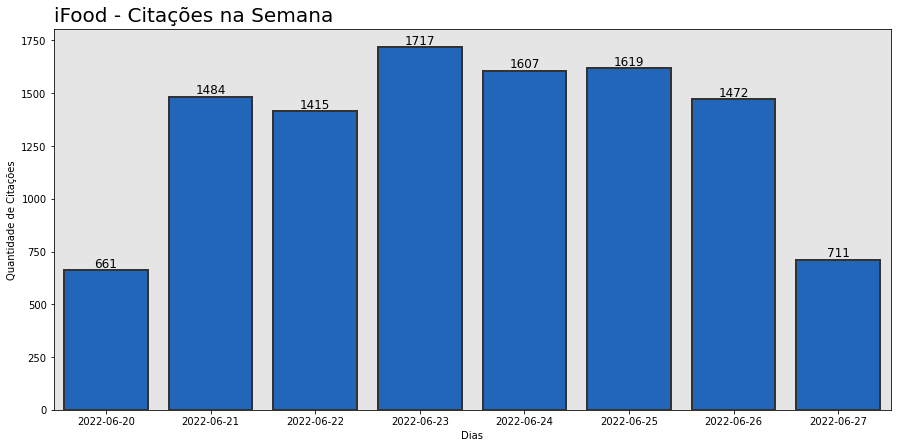

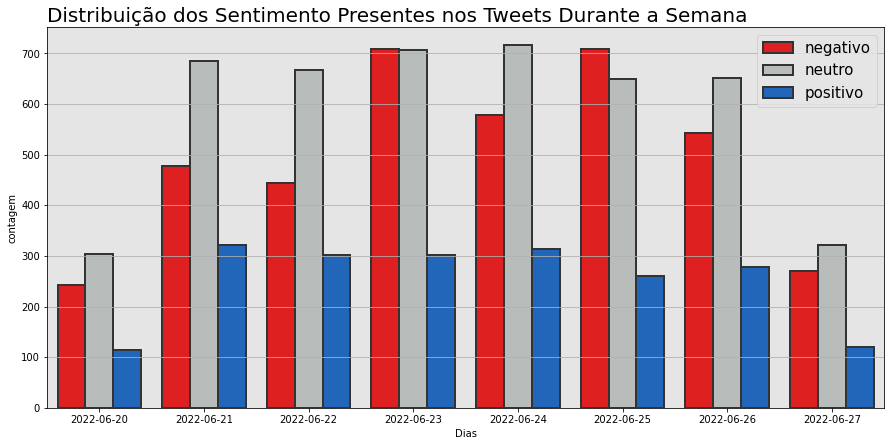

In [5]:
tweets_data['week_date'] = tweets_data['twt_date'].apply(lambda x: datetime.datetime.date(x))
tweets_data['contagem'] = 1

# Quantidade de citações na semana
temp = tweets_data.groupby('week_date')['contagem'].sum().reset_index()

plt.figure(figsize = (15,7))
sns.barplot(x = 'week_date',
             y = 'contagem',
             color = BLUE,
             linewidth = 2,
            edgecolor=".2",
             data = temp)
plt.suptitle('iFood - Citações na Semana', x = 0.255, y = 0.925, fontsize = 20)
plt.xlabel('Dias')
plt.ylabel('Quantidade de Citações')

for i in range(len(temp['week_date'])):
  plt.text(i, temp['contagem'].iloc[i], temp['contagem'].iloc[i], ha = 'center', va = 'bottom', fontsize = 12)

# Distribuição das citações
temp = tweets_data.groupby(['week_date', 'sentimento']).sum().reset_index()

plt.figure(figsize = (15, 7))
sns.barplot(x = 'week_date',
            y = 'contagem',
            hue = 'sentimento',
            linewidth = 2,
            edgecolor=".2",
            palette = [RED, '#B7BDBA', BLUE],
            data = temp)
plt.xlabel('Dias')
plt.suptitle(t = 'Distribuição dos Sentimento Presentes nos Tweets Durante a Semana', fontsize = 20, x = 0.449, y = 0.92)
plt.legend(bbox_to_anchor=(1, 1), fontsize=15)
plt.grid(axis = 'y')
plt.show()

## Usuarios

No gráfico abaixo temos o @ dos usuarios que mais citaram a marca durante a semana e a quantidade de menções.

O usuario @burrototal que fez 424 tweets mencionando o iFood na ultima semana publicou 421 de cunho negativo. Aparentemente essa conta assediava outros ussuarios os marcando em seus post e fazendo comentários negativos, felizmente o usuario já foi banido da plataforma e nem a empresa que era sempre citada, nem outros ussuarios serão prejudicados.

A página @iFoodNewsBrasil é na verdade uma página de novidades dentro do aplicativo.

Já a usuaria @EmillyHanah10, que postou 27 tweets mecionando a marca, teve problemas com o ressarcimento de uma compra, e por não ter conseguido resposta pelo aplicativo, mencionou a marca no Twitter cobrando resolução de seu problema.

Assim como o usuario @Eduardo60358982 que por conta de um problema de comunicação com a empresa, postou diversos tweets denegrindo a marca.


E essa história se repete entre muitos outros usuarios.

Estes problemas não resolvidos acabam por gerar repercussão nas redes sociais, a maioria dos consumidores insatisfeitos que foram listados aqui tem ao menos 300 seguidores no twitter. As postagens negativas tem uma média de 30 likes e 15 retweets. A longo prazo estes casos não resolvidos podem gerar gradativa queda na reputação da empresa.

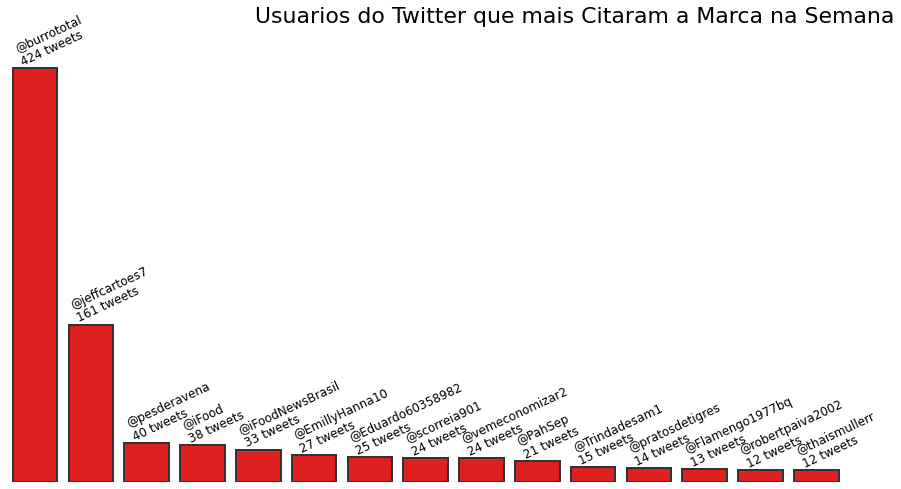

In [56]:
users_data_raw.drop('Unnamed: 0', axis = 1, inplace = True)
users_data_raw['user_id'] = users_data_raw['user_id'].astype(str)
temp = pd.merge(users_data_raw, tweets_data, on = 'user_id', how = 'right')
users_data = temp[['user_id', 'screen_name', 'verified', 'followers_count', 'sentimento']]

temp = tweets_data.groupby('user_id')['contagem'].sum().reset_index().sort_values(by = 'contagem',ascending = False).head(15)
temp = pd.merge(temp, users_data, on = 'user_id', how = 'left')
temp = temp[['user_id', 'contagem', 'screen_name', 'followers_count', 'sentimento', 'verified']]
temp.drop_duplicates('user_id', inplace = True)

plt.figure(figsize = (15, 8))
sns.barplot(x = 'screen_name',
            y = 'contagem',
            linewidth = 2,
            edgecolor=".2",
            color = RED,
            data = temp)
plt.xlabel('id dos usuarios')
plt.suptitle(t = 'Usuarios do Twitter que mais Citaram a Marca na Semana', fontsize = 22, x = 0.65, y = 0.95)

for x, y, screen_name in zip(list(range(0,15)), temp['contagem'], temp['screen_name']):
   plt.text(x-0.4, y, '@' + screen_name + '\n' + str(y) + ' tweets', fontsize = 12, ha = 'left', va = 'bottom', rotation = 25)

plt.axis('off')

plt.show()

## Tweets 

Nesta aba checamos quais os temas dos Tweets que mais tiveram repercussão durante a semana.

Através da WordCloud dos tweets negativos podemos perceber quais palavras são as mais presentes nas reclamações dos clientes. Dentre elas encontramos um grupo muito evidente de palavras : *atendimento*, *responde*, *resposta*, *chat*, *contato*, *ninguém*. Estas remetem a frequentes problemas relacionados ao suporte ao cliente dentro do aplicativo e por conta de seu grande volume na WordCloud podemos assumir que este foi o principal problema enfrentado pelos consumidores durante a semana.

Além disso encontramos também *chegou*, *saiu*, *atrasado*, *errado* e *endereço*. Palavras essas que remetem a problemas relacionados a restaurantes parceiros do aplicativo, como entregas atrasadas, entregas erradas e até mesmo erros de endereço.

Por fim, encontramos também as palavras *pagamento*, *cartão*, *reembolso*, que remetem a problemas nas compras pelo aplicativo e estornos. E as palavras *golpe* e *clonado* que são bastante auto-explicativas.

(-0.5, 2092.5, 1105.5, -0.5)

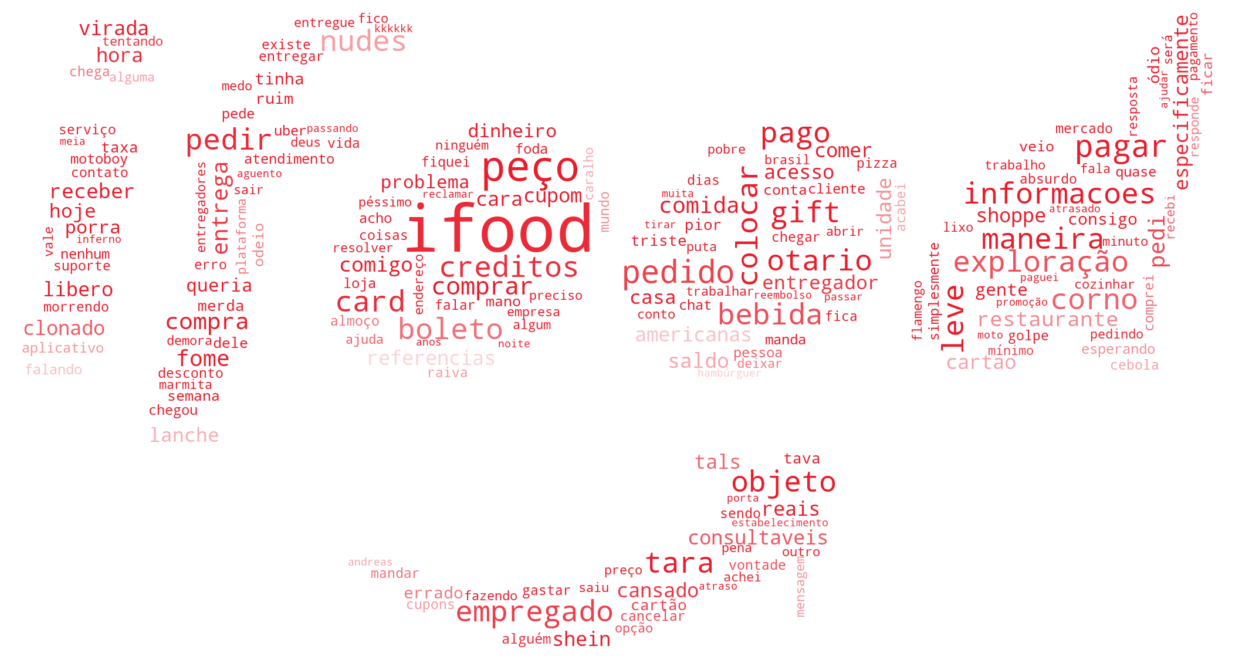

In [132]:
def cleaner(doc):
  temp = []
  for token in doc:
    if token.is_alpha and not token.is_stop and len(token.text) > 3:
      temp.append(token.text)
  return ' '.join(temp)

tweets_data['tweet_limpo'] = [cleaner(doc) for doc in nlp.pipe(cleaned_tweets, batch_size = 1000, n_process = 1)]

neg_tweets = tweets_data.loc[tweets_data['sentimento'] == 'negativo']

custom_mask = np.array(Image.open(('/content/drive/MyDrive/BASES DE DADOS/TWITTER DATA/iFood/png/ifood-43.png')))
wordcloud_ = WordCloud(width = 800, height = 500,
                        max_font_size = 110, collocations = False, mask = custom_mask,
                       background_color = 'white')

temp = ' '.join([palavra for palavra in neg_tweets['tweet_limpo']])
wordcloud_.generate(temp)
image_colors = ImageColorGenerator(custom_mask)
wordcloud_.recolor(color_func = image_colors)

plt.figure(figsize = (22,18))
plt.imshow(wordcloud_, interpolation = 'bilinear')
plt.axis('off')

# CONCLUSÃO E SUGGESTÕES

Através deste trabalho fomos capazes de descobrir a principal reclamação dos consumidores, o serviço de suporte ao cliente dentro do aplicativo. Muitas reclamações a respeito da demora pra responder(as vezes até falta de resposta) e dificuldade para estabelecer contato com o aplicativo quando o restaurante não se propõe a resolver o problema do cliente. Mediante isso uma possível contramedida simples para tratar este problema seria uma simples melhora no sistema de resposta aos pedidos de 'ajuda' dos clientes, agilizando avaliação e resposta. Tornar o sistema mais responsivo dá ao cliente maior conforto e segurança para consumir dentro do aplicativo, e evita que o mesmo possa levar sua reclamação a publico, e até denegrir a imagem da marca. No mercado atual reputação é um fator muito importante, e nos dias atuais informação, seja ela verídica ou não,  e opiniões, mesmo que equivocadas, se espalham muito rápido.
Uma primeira impressão negativa, ou até mesmo rumores negativos, podem fazer com que os clientes não tornem a consumir dentro do aplicativo. Por isso, uma equipe de resposta digital nas midias sociais, apta a entender o problema do cliente e propor uma solução seria uma boa alternativa para controlar o emprego do nome da empresa de maneira negativa nas redes sociais.

Futuramente, um novo trabalho para descobrir se o problema encontrado foi um marco exclusivo da semana analizada ou se é um problema recorrente é uma boa alternativa. Até mesmo para aprofundamento do problema.